In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In this notebook I apply logistic regression to two toy examples. My objective is to have a better understanding of the Newton-Raphson method for optimisation, used to fit a logistic regression model. 

## 1D example

In [2]:
data = pd.read_csv('../../datasets/logistic_regression_1d.csv')

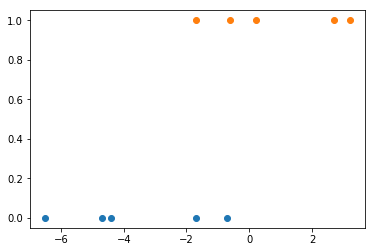

In [3]:
fig, ax = plt.subplots()
ax.plot(data[data.y == 0].x, data[data.y == 0].y, 'o')
ax.plot(data[data.y == 1].x, data[data.y == 1].y, 'o')

We have to fit a model in the following form:

$\text{logit}(y) = \beta_0 + \beta_1 x$

where $\text{logit}(y) = \text{ln}\left(\frac{y}{1 - y}\right)$, and therefore $y = \frac{e^{\beta_0 + \beta_1 x_{1,i} + \ldots + \beta_{k} x_{k,i}}}{1 + e^{\beta_0 + \beta_1 x_{1,i} + \ldots + \beta_{k} x_{k,i}}}$

We do this by applying iteratively reweighted least squares, which form is obtained after derivation based on the Newton-Raphson's method (see https://www.cs.cmu.edu/~mgormley/courses/10701-f16/slides/lecture5.pdf):

$\vec{\beta}_{n+1} = \vec{\beta}_n - \left(X^TSX\right)^{-1}\left(X^T(\mu - y)\right)$

where $S = \text{diag}(\mu_i(1 - \mu_i))$ is a diagonal matrix of weights and each weight is calculated as $\mu_i = 1/(1+e^{-\left(\beta_0 + \beta_1 x_{1,i} + \ldots + \beta_{k} x_{k,i}\right)})$.

A good method to initialise the coefficients before the first iteration (see https://statacumen.com/teach/SC1/SC1_11_LogisticRegression.pdf) is:

$\vec{\beta}_0 = \{\frac{\bar{y}}{1 - \bar{y}}, 0, \ldots, 0 \}$

In [4]:
def fit_logistic(x, y):
    '''
    Fits a logistic regression model. X and y should be m x n arrays, where m is the number
    of observartaions and n is the number of features
    '''
    X =  np.hstack((np.ones((x.shape[0], 1)), x))
    B = np.zeros((X.shape[1], 1))
    B[0] = math.log(np.mean(y) / (1 - np.mean(y)))
    prev_B = B + 1
    
    while np.sum(np.abs(B - prev_B)) > 0.001:
        prev_B = B
        
        mu = 1 / (1 + np.exp(-np.dot(X, B)))
        S = np.diag((mu * (1 - mu)).flatten())
        B = B - np.dot(np.linalg.inv(np.dot(np.dot(X.T, S), X)), np.dot(X.T, mu - y))
        print(B)
        
    return B

In [5]:
B = fit_logistic(data.x.values.reshape(-1, 1), data.y.values.reshape(-1, 1))

[[0.70566244]
 [0.49694538]]
[[1.10192   ]
 [0.80368937]]
[[1.41180924]
 [1.07366359]]
[[1.60574048]
 [1.25679074]]
[[1.66662791]
 [1.3152457 ]]
[[1.67098781]
 [1.31940786]]
[[1.67100738]
 [1.31942645]]


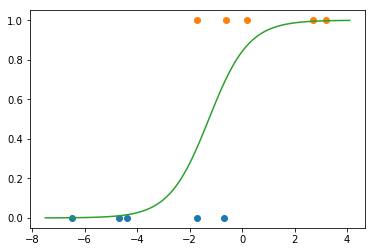

In [6]:
fig, ax = plt.subplots()
ax.plot(data[data.y == 0].x, data[data.y == 0].y, 'o')
ax.plot(data[data.y == 1].x, data[data.y == 1].y, 'o')

xs = []
ys = []
for x in np.arange(data.x.min() - 1, data.x.max() + 1, 0.1):
    y = math.exp(B[0] + B[1] * x) / (1 + math.exp(B[0] + B[1] * x))
    xs.append(x)
    ys.append(y)
ax.plot(xs, ys)

In [7]:
# Making predictions to show a confusion matrix
data['p'] = data['x'].apply(lambda x: math.exp(B[0] + B[1] * x) / (1 + math.exp(B[0] + B[1] * x)))
data['y_pred'] = data['p'].apply(lambda x: 1 if x > 0.5 else 0)

In [8]:
# Confusion matrix
data.groupby(['y', 'y_pred'])['x'].count().reset_index().pivot(index = 'y', columns = 'y_pred', values = 'x')

y_pred,0,1
y,,
0,4,1
1,1,4


## 2D example

In [9]:
data = pd.read_csv('../../datasets/logistic_regression_2d.csv')

In [10]:
B = fit_logistic(data[['Age', 'EstimatedSalary']].values, data.Purchased.values.reshape(-1, 1))

[[-6.10279063e+00]
 [ 1.15634425e-01]
 [ 1.66662351e-05]]
[[-9.47037575e+00]
 [ 1.77534056e-01]
 [ 2.69582270e-05]]
[[-1.16837485e+01]
 [ 2.19154057e-01]
 [ 3.36652513e-05]]
[[-1.23819258e+01]
 [ 2.32486803e-01]
 [ 3.57472387e-05]]
[[-1.24337310e+01]
 [ 2.33484471e-01]
 [ 3.59001821e-05]]
[[-1.24339881e+01]
 [ 2.33489442e-01]
 [ 3.59009382e-05]]


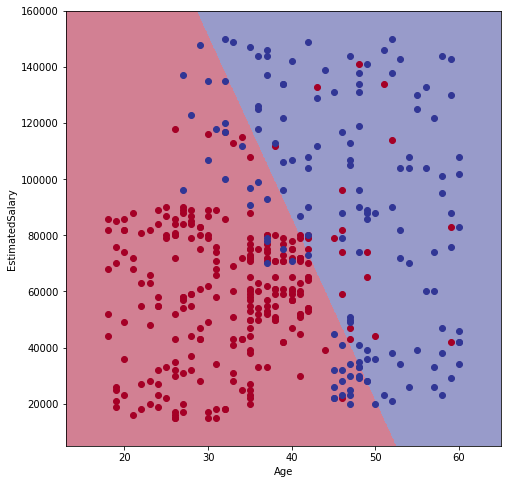

In [11]:
min_x = data['Age'].min() - 5
max_x = data['Age'].max() + 5
min_y = data['EstimatedSalary'].min() - 10000
max_y = data['EstimatedSalary'].max() + 10000
colormap = plt.cm.RdYlBu

fig, ax = plt.subplots()
x1 = np.linspace(min_x , max_x, 1000)
x2 = np.linspace(min_y, max_y, 1000)
xx1, xx2 = np.meshgrid(x1, x2)
lin = B[0] + xx1 * B[1] + xx2 * B[2]
res = ((np.exp(lin) / (1 + np.exp(lin))) > 0.5).astype(int)
ext = [min_x, max_x, min_y, max_y]
plt.imshow(res, zorder = 0, extent = ext, alpha = 0.5, cmap = colormap, origin = 'lower')

ax.scatter(data[data.Purchased == 0]['Age'], data[data.Purchased == 0]['EstimatedSalary'], c = colormap(0))
ax.scatter(data[data.Purchased == 1]['Age'], data[data.Purchased == 1]['EstimatedSalary'], c = colormap(256))
ax.set_xlabel('Age')
ax.set_ylabel('EstimatedSalary')

aspect = res.shape[0]/float(res.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)
fig.set_figwidth(8)
fig.set_figheight(8)

In [12]:
# Making predictions to show a confusion matrix
data['p'] = data[['Age', 'EstimatedSalary']].apply(lambda x: math.exp(B[0] + B[1] * x['Age'] + B[2] * x['EstimatedSalary']) / \
                                                             (1 + math.exp(B[0] + B[1] * x['Age'] + B[2] * x['EstimatedSalary'])),
                                                             axis = 1)
data['y_pred'] = data['p'].apply(lambda x: 1 if x > 0.5 else 0)

In [13]:
# Confusion matrix
data.groupby(['Purchased', 'y_pred'])['Age'] \
    .count() \
    .reset_index() \
    .rename(index = str, columns = {'Purchased': 'y'}) \
    .pivot(index = 'y', columns = 'y_pred', values = 'Age')

y_pred,0,1
y,,
0,236,21
1,41,102
